<a href="https://colab.research.google.com/github/GemmaGorey/Dissertation/blob/main/Similarity_Analysis_Audio_vsa_Lyrics_Features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()
# install mamba to use instead of pip

✨🍰✨ Everything looks OK!


In [3]:
# Create the config file and build the environment.
yaml_content = """
name: dissertation
channels:
  - pytorch
  - conda-forge
dependencies:
  - python=3.11
  - pytorch=2.2.2
  - torchvision=0.17.2
  - torchaudio
  - librosa
  - numpy<2
  - pandas
  - jupyter
  - wandb
"""

# Write the string content to a file -  'environment.yml'.
with open('environment.yml', 'w') as f:
    f.write(yaml_content)

print("environment.yml file created successfully.")

# create the environment using mamba from the yml file.
print("\n Creating environment")

!mamba env create -f environment.yml --quiet && echo -e "\n 'dissertation' environment is ready to use."

environment.yml file created successfully.

 Creating environment
Channels:
 - pytorch
 - conda-forge
Platform: linux-64
Solving environment: ...working... done
Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done

 'dissertation' environment is ready to use.


In [4]:
# imports and setting up of GitHub and W&B

# clone project repository from GitHub
print("⏳ Cloning GitHub repository...")
!git clone https://github.com/GemmaGorey/Dissertation.git
print("Repository cloned.")

#Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

#imports
import pandas as pd
import librosa
import os
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
from transformers import AutoTokenizer
from tqdm.auto import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from transformers import AutoModel
import torch.optim as optim
import wandb
import subprocess

print("Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased') #loading the tokenizer for lyrics processing
print("Tokenizer loaded.")

import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cross_decomposition import CCA
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')
import types
import json
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.spatial.distance import euclidean

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

⏳ Cloning GitHub repository...
Cloning into 'Dissertation'...
remote: Enumerating objects: 392, done.
remote: Counting objects: 100% (211/211), done.
remote: Compressing objects: 100% (141/141), done.
remote: Total 392 (delta 149), reused 82 (delta 70), pack-reused 181 (from 2)
Receiving objects: 100% (392/392), 5.46 MiB | 24.62 MiB/s, done.
Resolving deltas: 100% (206/206), done.
Repository cloned.
Mounted at /content/drive
Loading tokenizer...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Tokenizer loaded.


In [5]:
class MER_Dataset(Dataset):
    """ Custom PyTorch Dataset for loading MER data. """
    def __init__(self, annotations_df, tokenizer):
        """ Creation of the Dataset from the dataframe (predefined splits in MERGE dataset) """
        self.annotations = annotations_df
        self.tokenizer = tokenizer

    def __len__(self):
        """
        Function to return the total number of songs in the dataset.
        """
        return len(self.annotations)

    def __getitem__(self, index):
        """
        Function to get a song from the dataset.
        """
        song_info = self.annotations.iloc[index] #which song ID/row is picked from the dataset as per the index

        spectrogram_path = song_info['spectrogram_path'] # columns from the df
        lyrics_path = song_info['lyrics_path'] # columns from the df
        valence = song_info['valence'] # columns from the df
        arousal = song_info['arousal'] # columns from the df

        #change spectorgram into a tensor
        spectrogram = np.load(spectrogram_path) #loading spectorgram from path saved in df
        spectrogram_tensor = torch.from_numpy(spectrogram).float() # changing the np array to tensor
        spectrogram_tensor = spectrogram_tensor.unsqueeze(0) #Adding a "channel" dimension for CNN

        #Load the lyric tokens
        encoded_lyrics = torch.load(lyrics_path, weights_only=False)
        input_ids = encoded_lyrics['input_ids'].squeeze(0) #remove the batch dimension from input ids so 1d array
        attention_mask = encoded_lyrics['attention_mask'].squeeze(0) #remove the batch dimension from attention mask so 1d

        labels = torch.tensor([valence, arousal], dtype=torch.float32) # extract labels

        return spectrogram_tensor, input_ids, attention_mask, labels

In [6]:
class AttentionModule(nn.Module): #Addition from V1
    def __init__(self, feature_dim):
        super(AttentionModule, self).__init__()
        '''
        Attention mechanism to weight the importance of different features
        '''
        self.attention = nn.Sequential(
            nn.Linear(feature_dim, feature_dim // 4),  # input is 64 will map to16
            nn.ReLU(),
            nn.Linear(feature_dim // 4, feature_dim),  #reverts back to 64 from 16
            nn.Sigmoid()
        )

    def forward(self, x):
        # x shape: [batch_size, 64]
        attention_weights = self.attention(x)  # [batch_size, 64]
        weighted_features = x * attention_weights  # Element-wise multiplication
        return weighted_features

In [7]:
class VGGish_Audio_Model(nn.Module):
    '''As previous vERSION but adding in the following
      - Batch normalisation
      - Attention mechanism
      - Learning rate scheduling
      - early stopping'''

    def __init__(self):
        super(VGGish_Audio_Model, self).__init__()
        '''
        A VGG-style model for the audio tower for a starting model.
        No longer trying to implement the method from MERGE paper as this had mistakes in the paper
        V1.1 includes attention to see if this improves performance.
        V1.2  implements true VGG-style blocks with multiple convolutions per block.
        '''
        self.features = nn.Sequential(
            # Block 1 - 2 convolutions
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 2 - 2 convolutions
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 3 - 2 convolutions
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 4 - 2 convolutions
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        self.dropout1 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(512, 256)
        self.relu1 = nn.ReLU(inplace=True)
        self.dropout2 = nn.Dropout(0.5)
        self.attention = AttentionModule(256) #Add attention here from v2 (model 3)
        self.fc2 = nn.Linear(256, 64) # Final feature vector size should be 64 - needs to match input of combined

    def forward(self, x):
        x = self.features(x)
        # Flatten the features for the classifier
        x = x.view(x.size(0), -1)
        x = self.dropout1(x)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout2(x)
        x = self.attention(x)
        x = self.fc2(x)
        return x

In [8]:
class BimodalClassifier(nn.Module):
    """
    The final bimodal model. No longer using MERGE archtecture as
    transformer would be better. Also due to mistakes in the paper it is
    unclear what some of the parameters are.
    """
    def __init__(self):
        super(BimodalClassifier, self).__init__()

        #initiate audio tower
        self.audio_tower = VGGish_Audio_Model()

        #use transformer for lyrics (using bert base uncased for now, but may change)
        self.lyrics_tower = AutoModel.from_pretrained('bert-base-uncased')
        for param in self.lyrics_tower.parameters():
            param.requires_grad = False

        # Define feature sizes from the previous step and from bert
        AUDIO_FEATURES_OUT = 64
        LYRICS_FEATURES_OUT = 768
        COMBINED_FEATURES = AUDIO_FEATURES_OUT + LYRICS_FEATURES_OUT

        self.classifier_head = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features=COMBINED_FEATURES, out_features=100),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=100, out_features=2) # 2 Outputs for Valence and Arousal
        )

    def forward(self, x_audio, input_ids, attention_mask):
        #process audio input
        audio_features = self.audio_tower(x_audio)

        #get lyric features
        lyrics_outputs = self.lyrics_tower(input_ids=input_ids, attention_mask=attention_mask)

        #use the embedding of the [CLS] token as the feature vector for whole lyrics
        lyrics_features = lyrics_outputs.last_hidden_state[:, 0, :]

        #combine the features from both towers
        combined_features = torch.cat((audio_features, lyrics_features), dim=1)

        #pass the combined features to the final classifier head
        output = self.classifier_head(combined_features)

        return output

In [9]:
#Data loading and prep

#get the paths to dissertation folder and new folder on colab
print("Starting data transfer from Google Drive to local Colab storage...")

#get paths for old file location and new colab one
gdrive_zip_path = '/content/drive/MyDrive/dissertation/merge_dataset_zipped.zip'
local_storage_path = '/content/local_dissertation_data/'
local_zip_path = os.path.join(local_storage_path, 'merge_dataset_zipped.zip')
os.makedirs(local_storage_path, exist_ok=True) # Ensure the destination directory exists

#Copy zip file from Drive to Colab
print("Copying single archive file from Google Drive...")
!rsync -ah --progress "{gdrive_zip_path}" "{local_storage_path}"

#get total number of files for progress
total_files = int(subprocess.check_output(f"zipinfo -1 {local_zip_path} | wc -l", shell=True))

#unzip the file
print("Extracting files locally")
!unzip -o "{local_zip_path}" -d "{local_storage_path}" | tqdm --unit=files --total={total_files} > /dev/null

print("Data transfer and extraction complete.")

#load master data from new location
local_output_path = os.path.join(local_storage_path, 'merge_dataset/output_from_code/')
master_file_path = os.path.join(local_output_path, 'master_processed_file_list.csv')
master_df = pd.read_csv(master_file_path)

#checking the valence and arousal range in the dataset
print(f"\nValence range in data: [{master_df['valence'].min()}, {master_df['valence'].max()}]")
print(f"Arousal range in data: [{master_df['arousal'].min()}, {master_df['arousal'].max()}]")
print(f"Valence mean: {master_df['valence'].mean():.4f}, std: {master_df['valence'].std():.4f}")
print(f"Arousal mean: {master_df['arousal'].mean():.4f}, std: {master_df['arousal'].std():.4f}")
print(f"Total samples in master_df: {len(master_df)}")

# Verify its the right column - not quadrants
print(f"\nNumber of unique valence values: {master_df['valence'].nunique()}")
print(f"Number of unique arousal values: {master_df['arousal'].nunique()}")
print(f"Number of unique quadrant values: {master_df['quadrant'].nunique()}")

# Sample some actual values
print(f"\nSample valence values: {master_df['valence'].sample(10).values}")
print(f"Sample arousal values: {master_df['arousal'].sample(10).values}")

#update the paths in the csv
print("\nUpdating dataframe paths to use fast local storage...")
gdrive_output_path = '/content/drive/MyDrive/dissertation/output_from_code/'
master_df['spectrogram_path'] = master_df['spectrogram_path'].str.replace(gdrive_output_path, local_output_path, regex=False)
master_df['lyrics_path'] = master_df['lyrics_path'].str.replace(gdrive_output_path, local_output_path, regex=False)
print("Dataframe paths updated.")

#load the data splits from the new path in the predefined splits folder tvt
local_split_folder_path = os.path.join(local_storage_path, 'merge_dataset/MERGE_Bimodal_Complete/tvt_dataframes/tvt_70_15_15/')
train_split_df = pd.read_csv(os.path.join(local_split_folder_path, 'tvt_70_15_15_train_bimodal_complete.csv'))
val_split_df = pd.read_csv(os.path.join(local_split_folder_path, 'tvt_70_15_15_validate_bimodal_complete.csv'))
test_split_df = pd.read_csv(os.path.join(local_split_folder_path, 'tvt_70_15_15_test_bimodal_complete.csv'))
print("\nSplit files loaded from local storage.")

#merge the files
id_column_name = 'song_id'
train_split_df.rename(columns={'Song': id_column_name}, inplace=True)
val_split_df.rename(columns={'Song': id_column_name}, inplace=True)
test_split_df.rename(columns={'Song': id_column_name}, inplace=True)

train_df = pd.merge(master_df, train_split_df, on=id_column_name)
val_df = pd.merge(master_df, val_split_df, on=id_column_name)
test_df = pd.merge(master_df, test_split_df, on=id_column_name)

#checking no files are lost in merging - and checking length of the dataframes.
print("\nchecking data")

#check no data lost in merge
if len(train_df) == len(train_split_df):
    print("\nTraining split: Merge successful. All songs accounted for.")
else:
    print(f"\nWARNING: Training split lost {len(train_split_df) - len(train_df)} songs during merge.")

if len(val_df) == len(val_split_df):
    print("Validation split: Merge successful. All songs accounted for.")
else:
    print(f"WARNING: Validation split lost {len(val_split_df) - len(val_df)} songs during merge.")

if len(test_df) == len(test_split_df):
    print("Test split: Merge successful. All songs accounted for.")
else:
    print(f"WARNING: Test split lost {len(test_split_df) - len(test_df)} songs during merge.")

#check length
expected_train_len = 1552
expected_val_len = 332
expected_test_len = 332

assert len(train_df) == expected_train_len, f"Expected {expected_train_len} training samples, but found {len(train_df)}"
assert len(val_df) == expected_val_len, f"Expected {expected_val_len} validation samples, but found {len(val_df)}"
assert len(test_df) == expected_test_len, f"Expected {expected_test_len} test samples, but found {len(test_df)}"

print(f"\nFinal dataset lengths are correct: Train({len(train_df)}), Val({len(val_df)}), Test({len(test_df)})")
print("Data Check Complete")

#createthe datasets and loaders
train_dataset = MER_Dataset(annotations_df=train_df, tokenizer=tokenizer)
val_dataset = MER_Dataset(annotations_df=val_df, tokenizer=tokenizer)
test_dataset = MER_Dataset(annotations_df=test_df, tokenizer=tokenizer)

BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("\nDataLoaders created successfully.")

Starting data transfer from Google Drive to local Colab storage...
Copying single archive file from Google Drive...
sending incremental file list
merge_dataset_zipped.zip
          1.23G 100%   80.92MB/s    0:00:14 (xfr#1, to-chk=0/1)
Extracting files locally
4442files [00:16, 276.91files/s]           
Data transfer and extraction complete.

Valence range in data: [0.0187499999999999, 0.9875]
Arousal range in data: [0.0625, 0.975]
Valence mean: 0.5050, std: 0.2311
Arousal mean: 0.4823, std: 0.1395
Total samples in master_df: 2216

Number of unique valence values: 465
Number of unique arousal values: 443
Number of unique quadrant values: 4

Sample valence values: [0.30625  0.30875  0.49375  0.80625  0.36875  0.3425   0.336875 0.355625
 0.71     0.30625 ]
Sample arousal values: [0.454375 0.598125 0.37     0.5875   0.50625  0.314375 0.300625 0.56125
 0.684375 0.38625 ]

Updating dataframe paths to use fast local storage...
Dataframe paths updated.

Split files loaded from local storage.



In [10]:
# Check if a CUDA-enabled GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available. Using CUDA device.")
else:
    # If no GPU is found, print an error and stop execution by raising an error.
    raise RuntimeError("Error: No GPU found. This script requires a GPU to run.")


GPU is available. Using CUDA device.


In [11]:
class AudioOnlyModel(nn.Module):
    """Audio-only model for MER prediction using VGGish backbone."""
    def __init__(self):
        super(AudioOnlyModel, self).__init__()
        self.audio_tower = VGGish_Audio_Model()  # Same backbone as Bimodal

        # Regressor head for audio only
        self.regressor = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(64, 100),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(100, 2)  # Valence and Arousal
        )

    def forward(self, x_audio):
        audio_features = self.audio_tower(x_audio)
        predictions = self.regressor(audio_features)
        return predictions

class LyricsOnlyModel(nn.Module):
    """Lyrics-only model for MER prediction using BERT backbone."""
    def __init__(self):
        super(LyricsOnlyModel, self).__init__()
        self.lyrics_tower = AutoModel.from_pretrained('bert-base-uncased')
        for param in self.lyrics_tower.parameters():
            param.requires_grad = False # Freeze BERT weights

        # Regressor head for lyrics only
        self.regressor = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(768, 100),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(100, 2)  # Valence and Arousal
        )

    def forward(self, input_ids, attention_mask):
        lyrics_outputs = self.lyrics_tower(input_ids=input_ids, attention_mask=attention_mask)
        lyrics_features = lyrics_outputs.last_hidden_state[:, 0, :]  # [CLS] token
        predictions = self.regressor(lyrics_features)
        return predictions

# Initialise models and move to GPU
audio_only_model = AudioOnlyModel().to(device)
lyrics_only_model = LyricsOnlyModel().to(device)

print("Unimodal models initialised.")

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Unimodal models initialised.


In [12]:
# --- TRAINING CONFIGURATION (MATCHING MODEL 4) ---
NUM_EPOCHS = 50
LEARNING_RATE = 0.001
PATIENCE = 10

criterion = nn.MSELoss()

# 1. Audio Setup
audio_optimizer = optim.Adam(audio_only_model.parameters(), lr=LEARNING_RATE)
audio_scheduler = optim.lr_scheduler.StepLR(audio_optimizer, step_size=15, gamma=0.5)

# 2. Lyrics Setup
lyrics_optimizer = optim.Adam([p for p in lyrics_only_model.parameters() if p.requires_grad], lr=LEARNING_RATE)
lyrics_scheduler = optim.lr_scheduler.StepLR(lyrics_optimizer, step_size=15, gamma=0.5)

print(f"Configuration Loaded: Epochs={NUM_EPOCHS}, LR={LEARNING_RATE}, Patience={PATIENCE}")
print("Schedulers: StepLR (step=15, gamma=0.5)")

Configuration Loaded: Epochs=50, LR=0.001, Patience=10
Schedulers: StepLR (step=15, gamma=0.5)


In [13]:
print("\n" + "="*70)
print("TRAINING AUDIO-ONLY MODEL")
print("="*70)

# Initialize Early Stopping Variables
best_val_loss = float('inf')
patience_counter = 0
best_audio_state = None

wandb.init(project="dissertation-unimodal", name="audio-only-training")

for epoch in range(NUM_EPOCHS):
    # --- TRAINING ---
    audio_only_model.train()
    total_train_loss = 0

    for spectrogram_batch, _, _, labels_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]"):
        spectrogram_batch = spectrogram_batch.to(device)
        labels_batch = labels_batch.to(device)

        audio_optimizer.zero_grad()

        # Forward pass
        batch_predictions = audio_only_model(spectrogram_batch)
        loss = criterion(batch_predictions, labels_batch)

        # Backward pass
        loss.backward()

        # Gradient Clipping (From Model 4)
        torch.nn.utils.clip_grad_norm_(audio_only_model.parameters(), max_norm=1.0)

        audio_optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)

    # --- VALIDATION ---
    audio_only_model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for spectrogram_batch, _, _, labels_batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Val]"):
            spectrogram_batch = spectrogram_batch.to(device)
            labels_batch = labels_batch.to(device)

            batch_predictions = audio_only_model(spectrogram_batch)
            loss = criterion(batch_predictions, labels_batch)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)

    # --- LOGGING & SCHEDULER ---
    print(f"Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    wandb.log({"audio_train_loss": avg_train_loss, "audio_val_loss": avg_val_loss, "epoch": epoch+1})

    # Early Stopping Logic (From Model 4)
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        best_audio_state = audio_only_model.state_dict().copy()
        # Save locally
        torch.save(audio_only_model.state_dict(), 'best_audio_model.pth')
        print(f"  ✓ New best model saved (Val Loss: {best_val_loss:.4f})")
    else:
        patience_counter += 1
        print(f"  No improvement ({patience_counter}/{PATIENCE})")
        if patience_counter >= PATIENCE:
            print("  ! Early stopping triggered")
            audio_only_model.load_state_dict(best_audio_state)
            break

    # Step the scheduler (From Model 4)
    audio_scheduler.step()

print("Audio Training Complete.")
wandb.finish()


TRAINING AUDIO-ONLY MODEL


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: gemwrigley (gemwrigley-university-of-bath) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch 1/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 1/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 1 - Train Loss: 0.0733, Val Loss: 0.0399
  ✓ New best model saved (Val Loss: 0.0399)


Epoch 2/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 2/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 2 - Train Loss: 0.0537, Val Loss: 0.0420
  No improvement (1/10)


Epoch 3/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 3/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 3 - Train Loss: 0.0422, Val Loss: 0.0350
  ✓ New best model saved (Val Loss: 0.0350)


Epoch 4/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 4/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 4 - Train Loss: 0.0406, Val Loss: 0.0329
  ✓ New best model saved (Val Loss: 0.0329)


Epoch 5/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 5/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 0.0368, Val Loss: 0.0280
  ✓ New best model saved (Val Loss: 0.0280)


Epoch 6/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 6/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 6 - Train Loss: 0.0363, Val Loss: 0.0302
  No improvement (1/10)


Epoch 7/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 7/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 7 - Train Loss: 0.0356, Val Loss: 0.0290
  No improvement (2/10)


Epoch 8/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 8/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 8 - Train Loss: 0.0344, Val Loss: 0.0256
  ✓ New best model saved (Val Loss: 0.0256)


Epoch 9/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 9/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 9 - Train Loss: 0.0340, Val Loss: 0.0281
  No improvement (1/10)


Epoch 10/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 10/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 10 - Train Loss: 0.0335, Val Loss: 0.0307
  No improvement (2/10)


Epoch 11/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 11/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 11 - Train Loss: 0.0327, Val Loss: 0.0278
  No improvement (3/10)


Epoch 12/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 12/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 12 - Train Loss: 0.0329, Val Loss: 0.0343
  No improvement (4/10)


Epoch 13/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 13/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 13 - Train Loss: 0.0327, Val Loss: 0.0247
  ✓ New best model saved (Val Loss: 0.0247)


Epoch 14/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 14/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 14 - Train Loss: 0.0323, Val Loss: 0.0340
  No improvement (1/10)


Epoch 15/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 15/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 15 - Train Loss: 0.0319, Val Loss: 0.0247
  ✓ New best model saved (Val Loss: 0.0247)


Epoch 16/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 16/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 16 - Train Loss: 0.0314, Val Loss: 0.0232
  ✓ New best model saved (Val Loss: 0.0232)


Epoch 17/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 17/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 17 - Train Loss: 0.0299, Val Loss: 0.0231
  ✓ New best model saved (Val Loss: 0.0231)


Epoch 18/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 18/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 18 - Train Loss: 0.0287, Val Loss: 0.0270
  No improvement (1/10)


Epoch 19/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 19/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 19 - Train Loss: 0.0302, Val Loss: 0.0244
  No improvement (2/10)


Epoch 20/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 20/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 20 - Train Loss: 0.0283, Val Loss: 0.0236
  No improvement (3/10)


Epoch 21/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 21/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 21 - Train Loss: 0.0280, Val Loss: 0.0221
  ✓ New best model saved (Val Loss: 0.0221)


Epoch 22/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 22/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 22 - Train Loss: 0.0279, Val Loss: 0.0231
  No improvement (1/10)


Epoch 23/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 23/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 23 - Train Loss: 0.0276, Val Loss: 0.0225
  No improvement (2/10)


Epoch 24/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 24/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 24 - Train Loss: 0.0270, Val Loss: 0.0243
  No improvement (3/10)


Epoch 25/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 25/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 25 - Train Loss: 0.0270, Val Loss: 0.0299
  No improvement (4/10)


Epoch 26/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 26/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 26 - Train Loss: 0.0275, Val Loss: 0.0220
  ✓ New best model saved (Val Loss: 0.0220)


Epoch 27/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 27/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 27 - Train Loss: 0.0271, Val Loss: 0.0244
  No improvement (1/10)


Epoch 28/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 28/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 28 - Train Loss: 0.0270, Val Loss: 0.0236
  No improvement (2/10)


Epoch 29/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 29/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 29 - Train Loss: 0.0260, Val Loss: 0.0210
  ✓ New best model saved (Val Loss: 0.0210)


Epoch 30/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 30/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 30 - Train Loss: 0.0260, Val Loss: 0.0239
  No improvement (1/10)


Epoch 31/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 31/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 31 - Train Loss: 0.0259, Val Loss: 0.0211
  No improvement (2/10)


Epoch 32/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 32/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 32 - Train Loss: 0.0253, Val Loss: 0.0229
  No improvement (3/10)


Epoch 33/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 33/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 33 - Train Loss: 0.0259, Val Loss: 0.0280
  No improvement (4/10)


Epoch 34/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 34/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 34 - Train Loss: 0.0249, Val Loss: 0.0201
  ✓ New best model saved (Val Loss: 0.0201)


Epoch 35/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 35/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 35 - Train Loss: 0.0248, Val Loss: 0.0210
  No improvement (1/10)


Epoch 36/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 36/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 36 - Train Loss: 0.0258, Val Loss: 0.0200
  ✓ New best model saved (Val Loss: 0.0200)


Epoch 37/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 37/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 37 - Train Loss: 0.0251, Val Loss: 0.0223
  No improvement (1/10)


Epoch 38/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 38/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 38 - Train Loss: 0.0251, Val Loss: 0.0225
  No improvement (2/10)


Epoch 39/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 39/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 39 - Train Loss: 0.0240, Val Loss: 0.0207
  No improvement (3/10)


Epoch 40/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 40/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 40 - Train Loss: 0.0241, Val Loss: 0.0225
  No improvement (4/10)


Epoch 41/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 41/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 41 - Train Loss: 0.0250, Val Loss: 0.0211
  No improvement (5/10)


Epoch 42/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 42/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 42 - Train Loss: 0.0238, Val Loss: 0.0228
  No improvement (6/10)


Epoch 43/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 43/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 43 - Train Loss: 0.0248, Val Loss: 0.0212
  No improvement (7/10)


Epoch 44/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 44/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 44 - Train Loss: 0.0251, Val Loss: 0.0217
  No improvement (8/10)


Epoch 45/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 45/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 45 - Train Loss: 0.0244, Val Loss: 0.0233
  No improvement (9/10)


Epoch 46/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 46/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 46 - Train Loss: 0.0237, Val Loss: 0.0206
  No improvement (10/10)
  ! Early stopping triggered
Audio Training Complete.


audio_train_loss,█▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
audio_val_loss,▇█▆▅▄▄▄▄▄▄▆▃▅▃▂▃▂▂▂▂▂▄▂▂▂▁▂▂▄▁▁▁▂▁▂▁▂▁▂▂
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
audio_train_loss,0.02365
audio_val_loss,0.02064
epoch,46


In [14]:
print("\n" + "="*70)
print("TRAINING LYRICS-ONLY MODEL")
print("="*70)

# Initialize Early Stopping Variables
best_val_loss = float('inf')
patience_counter = 0
best_lyrics_state = None

wandb.init(project="dissertation-unimodal", name="lyrics-only-training")

for epoch in range(NUM_EPOCHS):
    # --- TRAINING ---
    lyrics_only_model.train()
    total_train_loss = 0

    for _, input_ids_batch, attention_mask_batch, labels_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]"):
        input_ids_batch = input_ids_batch.to(device)
        attention_mask_batch = attention_mask_batch.to(device)
        labels_batch = labels_batch.to(device)

        lyrics_optimizer.zero_grad()

        # Forward pass
        batch_predictions = lyrics_only_model(input_ids_batch, attention_mask_batch)
        loss = criterion(batch_predictions, labels_batch)

        # Backward pass
        loss.backward()

        # Gradient Clipping (From Model 4)
        torch.nn.utils.clip_grad_norm_(lyrics_only_model.parameters(), max_norm=1.0)

        lyrics_optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)

    # --- VALIDATION ---
    lyrics_only_model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for _, input_ids_batch, attention_mask_batch, labels_batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Val]"):
            input_ids_batch = input_ids_batch.to(device)
            attention_mask_batch = attention_mask_batch.to(device)
            labels_batch = labels_batch.to(device)

            batch_predictions = lyrics_only_model(input_ids_batch, attention_mask_batch)
            loss = criterion(batch_predictions, labels_batch)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)

    # --- LOGGING & SCHEDULER ---
    print(f"Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    wandb.log({"lyrics_train_loss": avg_train_loss, "lyrics_val_loss": avg_val_loss, "epoch": epoch+1})

    # Early Stopping Logic (From Model 4)
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        best_lyrics_state = lyrics_only_model.state_dict().copy()
        # Save locally
        torch.save(lyrics_only_model.state_dict(), 'best_lyrics_model.pth')
        print(f"  ✓ New best model saved (Val Loss: {best_val_loss:.4f})")
    else:
        patience_counter += 1
        print(f"  No improvement ({patience_counter}/{PATIENCE})")
        if patience_counter >= PATIENCE:
            print("  ! Early stopping triggered")
            lyrics_only_model.load_state_dict(best_lyrics_state)
            break

    # Step the scheduler (From Model 4)
    lyrics_scheduler.step()

print("Lyrics Training Complete.")
wandb.finish()


TRAINING LYRICS-ONLY MODEL


Epoch 1/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 1/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 1 - Train Loss: 0.0705, Val Loss: 0.0245
  ✓ New best model saved (Val Loss: 0.0245)


Epoch 2/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 2/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 2 - Train Loss: 0.0435, Val Loss: 0.0231
  ✓ New best model saved (Val Loss: 0.0231)


Epoch 3/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 3/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 3 - Train Loss: 0.0421, Val Loss: 0.0260
  No improvement (1/10)


Epoch 4/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 4/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 4 - Train Loss: 0.0372, Val Loss: 0.0226
  ✓ New best model saved (Val Loss: 0.0226)


Epoch 5/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 5/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 0.0353, Val Loss: 0.0241
  No improvement (1/10)


Epoch 6/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 6/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 6 - Train Loss: 0.0340, Val Loss: 0.0219
  ✓ New best model saved (Val Loss: 0.0219)


Epoch 7/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 7/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 7 - Train Loss: 0.0308, Val Loss: 0.0214
  ✓ New best model saved (Val Loss: 0.0214)


Epoch 8/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 8/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 8 - Train Loss: 0.0300, Val Loss: 0.0230
  No improvement (1/10)


Epoch 9/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 9/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 9 - Train Loss: 0.0299, Val Loss: 0.0219
  No improvement (2/10)


Epoch 10/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 10/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 10 - Train Loss: 0.0292, Val Loss: 0.0213
  ✓ New best model saved (Val Loss: 0.0213)


Epoch 11/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 11/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 11 - Train Loss: 0.0301, Val Loss: 0.0206
  ✓ New best model saved (Val Loss: 0.0206)


Epoch 12/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 12/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 12 - Train Loss: 0.0273, Val Loss: 0.0210
  No improvement (1/10)


Epoch 13/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 13/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 13 - Train Loss: 0.0270, Val Loss: 0.0217
  No improvement (2/10)


Epoch 14/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 14/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 14 - Train Loss: 0.0274, Val Loss: 0.0222
  No improvement (3/10)


Epoch 15/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 15/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 15 - Train Loss: 0.0261, Val Loss: 0.0211
  No improvement (4/10)


Epoch 16/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 16/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 16 - Train Loss: 0.0253, Val Loss: 0.0211
  No improvement (5/10)


Epoch 17/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 17/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 17 - Train Loss: 0.0253, Val Loss: 0.0213
  No improvement (6/10)


Epoch 18/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 18/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 18 - Train Loss: 0.0255, Val Loss: 0.0203
  ✓ New best model saved (Val Loss: 0.0203)


Epoch 19/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 19/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 19 - Train Loss: 0.0256, Val Loss: 0.0206
  No improvement (1/10)


Epoch 20/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 20/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 20 - Train Loss: 0.0256, Val Loss: 0.0202
  ✓ New best model saved (Val Loss: 0.0202)


Epoch 21/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 21/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 21 - Train Loss: 0.0250, Val Loss: 0.0203
  No improvement (1/10)


Epoch 22/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 22/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 22 - Train Loss: 0.0257, Val Loss: 0.0202
  ✓ New best model saved (Val Loss: 0.0202)


Epoch 23/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 23/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 23 - Train Loss: 0.0248, Val Loss: 0.0204
  No improvement (1/10)


Epoch 24/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 24/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 24 - Train Loss: 0.0239, Val Loss: 0.0200
  ✓ New best model saved (Val Loss: 0.0200)


Epoch 25/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 25/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 25 - Train Loss: 0.0249, Val Loss: 0.0200
  ✓ New best model saved (Val Loss: 0.0200)


Epoch 26/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 26/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 26 - Train Loss: 0.0254, Val Loss: 0.0199
  ✓ New best model saved (Val Loss: 0.0199)


Epoch 27/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 27/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 27 - Train Loss: 0.0252, Val Loss: 0.0201
  No improvement (1/10)


Epoch 28/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 28/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 28 - Train Loss: 0.0247, Val Loss: 0.0199
  ✓ New best model saved (Val Loss: 0.0199)


Epoch 29/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 29/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 29 - Train Loss: 0.0240, Val Loss: 0.0199
  ✓ New best model saved (Val Loss: 0.0199)


Epoch 30/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 30/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 30 - Train Loss: 0.0249, Val Loss: 0.0200
  No improvement (1/10)


Epoch 31/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 31/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 31 - Train Loss: 0.0247, Val Loss: 0.0199
  No improvement (2/10)


Epoch 32/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 32/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 32 - Train Loss: 0.0248, Val Loss: 0.0201
  No improvement (3/10)


Epoch 33/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 33/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 33 - Train Loss: 0.0242, Val Loss: 0.0198
  ✓ New best model saved (Val Loss: 0.0198)


Epoch 34/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 34/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 34 - Train Loss: 0.0246, Val Loss: 0.0197
  ✓ New best model saved (Val Loss: 0.0197)


Epoch 35/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 35/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 35 - Train Loss: 0.0238, Val Loss: 0.0199
  No improvement (1/10)


Epoch 36/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 36/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 36 - Train Loss: 0.0237, Val Loss: 0.0198
  No improvement (2/10)


Epoch 37/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 37/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 37 - Train Loss: 0.0241, Val Loss: 0.0196
  ✓ New best model saved (Val Loss: 0.0196)


Epoch 38/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 38/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 38 - Train Loss: 0.0242, Val Loss: 0.0198
  No improvement (1/10)


Epoch 39/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 39/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 39 - Train Loss: 0.0237, Val Loss: 0.0198
  No improvement (2/10)


Epoch 40/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 40/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 40 - Train Loss: 0.0243, Val Loss: 0.0198
  No improvement (3/10)


Epoch 41/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 41/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 41 - Train Loss: 0.0238, Val Loss: 0.0196
  ✓ New best model saved (Val Loss: 0.0196)


Epoch 42/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 42/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 42 - Train Loss: 0.0242, Val Loss: 0.0197
  No improvement (1/10)


Epoch 43/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 43/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 43 - Train Loss: 0.0243, Val Loss: 0.0198
  No improvement (2/10)


Epoch 44/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 44/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 44 - Train Loss: 0.0235, Val Loss: 0.0197
  No improvement (3/10)


Epoch 45/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 45/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 45 - Train Loss: 0.0240, Val Loss: 0.0198
  No improvement (4/10)


Epoch 46/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 46/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 46 - Train Loss: 0.0235, Val Loss: 0.0197
  No improvement (5/10)


Epoch 47/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 47/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 47 - Train Loss: 0.0242, Val Loss: 0.0197
  No improvement (6/10)


Epoch 48/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 48/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 48 - Train Loss: 0.0239, Val Loss: 0.0197
  No improvement (7/10)


Epoch 49/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 49/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 49 - Train Loss: 0.0238, Val Loss: 0.0198
  No improvement (8/10)


Epoch 50/50 [Train]:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 50/50 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 50 - Train Loss: 0.0239, Val Loss: 0.0196
  No improvement (9/10)
Lyrics Training Complete.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
lyrics_train_loss,█▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lyrics_val_loss,▆▅█▄▆▅▃▃▂▃▃▃▃▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,50
lyrics_train_loss,0.02387
lyrics_val_loss,0.01965


In [15]:
def extract_and_compare_models(audio_model, lyrics_model, dataloader, device):
    """Runs test set through both models and returns predictions."""

    audio_preds_list = []
    lyrics_preds_list = []
    ground_truth_list = []

    audio_model.eval()
    lyrics_model.eval()

    print("\nExtracting Final Predictions on Test Set...")
    with torch.no_grad():
        for spectrogram_batch, input_ids_batch, attention_mask_batch, labels_batch in tqdm(dataloader):
            # Move to device
            spectrogram_batch = spectrogram_batch.to(device)
            input_ids_batch = input_ids_batch.to(device)
            attention_mask_batch = attention_mask_batch.to(device)

            # Audio Prediction
            a_pred = audio_model(spectrogram_batch)
            audio_preds_list.append(a_pred.cpu().numpy())

            # Lyrics Prediction
            l_pred = lyrics_model(input_ids_batch, attention_mask_batch)
            lyrics_preds_list.append(l_pred.cpu().numpy())

            # Ground Truth
            ground_truth_list.append(labels_batch.cpu().numpy())

    # Concatenate
    audio_predictions = np.concatenate(audio_preds_list, axis=0)
    lyrics_predictions = np.concatenate(lyrics_preds_list, axis=0)
    ground_truth = np.concatenate(ground_truth_list, axis=0)

    # Calculate MSE for quick check
    audio_mse = mean_squared_error(ground_truth, audio_predictions)
    lyrics_mse = mean_squared_error(ground_truth, lyrics_predictions)

    print(f"\nRESULTS:")
    print(f"Audio-Only MSE:  {audio_mse:.4f}")
    print(f"Lyrics-Only MSE: {lyrics_mse:.4f}")

    return audio_predictions, lyrics_predictions, ground_truth

# Run extraction
audio_preds, lyrics_preds, ground_truth = extract_and_compare_models(
    audio_only_model,
    lyrics_only_model,
    test_loader,
    device
)

# Save variables for the next steps (Similarity Analysis)
print("Predictions extracted. Ready for Similarity Analysis (PCA/CCA).")


Extracting Final Predictions on Test Set...


  0%|          | 0/21 [00:00<?, ?it/s]


RESULTS:
Audio-Only MSE:  0.0195
Lyrics-Only MSE: 0.0175
Predictions extracted. Ready for Similarity Analysis (PCA/CCA).


In [16]:


print("\n" + "="*70)
print("SAVING MODELS AND EXPORTING RESULTS")
print("="*70)

# 1. Setup Output Paths
# Using the dissertation folder on Google Drive
output_dir = '/content/drive/MyDrive/dissertation/'
os.makedirs(output_dir, exist_ok=True)

# 2. Save the Model Weights
# We save the state_dict (weights) so they can be loaded later
audio_weights_path = os.path.join(output_dir, 'audio_only_vggish_model_4_params.pth')
lyrics_weights_path = os.path.join(output_dir, 'lyrics_only_bert_model_4_params.pth')

torch.save(audio_only_model.state_dict(), audio_weights_path)
print(f"✓ Audio Model weights saved to: {audio_weights_path}")

torch.save(lyrics_only_model.state_dict(), lyrics_weights_path)
print(f"✓ Lyrics Model weights saved to: {lyrics_weights_path}")

# 3. Create and Save the Excel Report
# We use the 'test_df' to get the Song IDs, then add our predictions
export_df = test_df[[id_column_name]].copy() # Start with Song IDs

# Add Ground Truth (Actual values)
export_df['ground_truth_valence'] = ground_truth[:, 0]
export_df['ground_truth_arousal'] = ground_truth[:, 1]

# Add Audio-Only Predictions
export_df['audio_pred_valence'] = audio_preds[:, 0]
export_df['audio_pred_arousal'] = audio_preds[:, 1]

# Add Lyrics-Only Predictions
export_df['lyrics_pred_valence'] = lyrics_preds[:, 0]
export_df['lyrics_pred_arousal'] = lyrics_preds[:, 1]

# Calculate absolute errors for quick analysis in Excel
export_df['audio_valence_error'] = abs(export_df['ground_truth_valence'] - export_df['audio_pred_valence'])
export_df['lyrics_valence_error'] = abs(export_df['ground_truth_valence'] - export_df['lyrics_pred_valence'])

# Save to Excel
excel_output_path = os.path.join(output_dir, 'unimodal_model_4_results_per_song.xlsx')
export_df.to_excel(excel_output_path, index=False)

print(f"✓ Detailed Excel report saved to: {excel_output_path}")
print(f"  (Contains {len(export_df)} songs with ID, Ground Truth, and Predictions)")


SAVING MODELS AND EXPORTING RESULTS
✓ Audio Model weights saved to: /content/drive/MyDrive/dissertation/audio_only_vggish_model_4_params.pth
✓ Lyrics Model weights saved to: /content/drive/MyDrive/dissertation/lyrics_only_bert_model_4_params.pth
✓ Detailed Excel report saved to: /content/drive/MyDrive/dissertation/unimodal_model_4_results_per_song.xlsx
  (Contains 332 songs with ID, Ground Truth, and Predictions)


In [17]:
import os

# --- TRAINING CONFIGURATION (MODEL 4) ---
NUM_EPOCHS = 50
LEARNING_RATE = 0.001
PATIENCE = 10
output_dir = '/content/drive/MyDrive/dissertation/'

# Define the exact filenames we are looking for
audio_weights_path = os.path.join(output_dir, 'audio_only_vggish_model_4_params.pth')
lyrics_weights_path = os.path.join(output_dir, 'lyrics_only_bert_model_4_params.pth')

criterion = nn.MSELoss()

# --- CHECK: DO MODELS ALREADY EXIST? ---
print("\n" + "="*70)
print("CHECKING FOR EXISTING MODELS")
print("="*70)

# 1. Check Audio
audio_needs_training = True
if os.path.exists(audio_weights_path):
    try:
        audio_only_model.load_state_dict(torch.load(audio_weights_path, map_location=device))
        audio_needs_training = False
        print(f"FOUND existing Audio model: {audio_weights_path}")
        print("  > Loaded weights. Skipping training.")
    except Exception as e:
        print(f"⚠ Found file but could not load (Error: {e}). Will retrain.")
else:
    print(f"No existing Audio model found. Will proceed with training.")

# 2. Check Lyrics
lyrics_needs_training = True
if os.path.exists(lyrics_weights_path):
    try:
        lyrics_only_model.load_state_dict(torch.load(lyrics_weights_path, map_location=device))
        lyrics_needs_training = False
        print(f"FOUND existing Lyrics model: {lyrics_weights_path}")
        print("  > Loaded weights. Skipping training.")
    except Exception as e:
        print(f"Found file but could not load (Error: {e}). Will retrain.")
else:
    print(f"No existing Lyrics model found. Will proceed with training.")

# Setup Optimizers (We define them anyway, just in case we need to train)
audio_optimizer = optim.Adam(audio_only_model.parameters(), lr=LEARNING_RATE)
audio_scheduler = optim.lr_scheduler.StepLR(audio_optimizer, step_size=15, gamma=0.5)

lyrics_optimizer = optim.Adam([p for p in lyrics_only_model.parameters() if p.requires_grad], lr=LEARNING_RATE)
lyrics_scheduler = optim.lr_scheduler.StepLR(lyrics_optimizer, step_size=15, gamma=0.5)


CHECKING FOR EXISTING MODELS
FOUND existing Audio model: /content/drive/MyDrive/dissertation/audio_only_vggish_model_4_params.pth
  > Loaded weights. Skipping training.
FOUND existing Lyrics model: /content/drive/MyDrive/dissertation/lyrics_only_bert_model_4_params.pth
  > Loaded weights. Skipping training.


In [18]:
if audio_needs_training:
    print("\n" + "="*70)
    print("TRAINING AUDIO-ONLY MODEL")
    print("="*70)

    # Initialize Early Stopping Variables
    best_val_loss = float('inf')
    patience_counter = 0
    best_audio_state = None

    wandb.init(project="dissertation-unimodal", name="audio-only-training")

    for epoch in range(NUM_EPOCHS):
        # --- TRAINING ---
        audio_only_model.train()
        total_train_loss = 0

        for spectrogram_batch, _, _, labels_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]"):
            spectrogram_batch = spectrogram_batch.to(device)
            labels_batch = labels_batch.to(device)

            audio_optimizer.zero_grad()

            # Forward pass
            batch_predictions = audio_only_model(spectrogram_batch)
            loss = criterion(batch_predictions, labels_batch)

            # Backward pass
            loss.backward()

            # Gradient Clipping (Model 4)
            torch.nn.utils.clip_grad_norm_(audio_only_model.parameters(), max_norm=1.0)

            audio_optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)

        # --- VALIDATION ---
        audio_only_model.eval()
        total_val_loss = 0

        with torch.no_grad():
            for spectrogram_batch, _, _, labels_batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Val]"):
                spectrogram_batch = spectrogram_batch.to(device)
                labels_batch = labels_batch.to(device)

                batch_predictions = audio_only_model(spectrogram_batch)
                loss = criterion(batch_predictions, labels_batch)
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)

        # --- LOGGING & SCHEDULER ---
        print(f"Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        wandb.log({"audio_train_loss": avg_train_loss, "audio_val_loss": avg_val_loss, "epoch": epoch+1})

        # Early Stopping Logic
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            best_audio_state = audio_only_model.state_dict().copy()
            print(f"  ✓ New best model found (Val Loss: {best_val_loss:.4f})")
        else:
            patience_counter += 1
            print(f"  No improvement ({patience_counter}/{PATIENCE})")
            if patience_counter >= PATIENCE:
                print("  ! Early stopping triggered")
                audio_only_model.load_state_dict(best_audio_state)
                break

        audio_scheduler.step()

    # Save the trained model immediately so we don't have to retrain next time
    torch.save(audio_only_model.state_dict(), audio_weights_path)
    print(f"✓ Audio Training Complete. Weights saved to {audio_weights_path}")
    wandb.finish()

else:
    print("--- SKIPPING AUDIO TRAINING (Model already loaded) ---")

--- SKIPPING AUDIO TRAINING (Model already loaded) ---


In [19]:
if lyrics_needs_training:
    print("\n" + "="*70)
    print("TRAINING LYRICS-ONLY MODEL")
    print("="*70)

    # Initialize Early Stopping Variables
    best_val_loss = float('inf')
    patience_counter = 0
    best_lyrics_state = None

    wandb.init(project="dissertation-unimodal", name="lyrics-only-training")

    for epoch in range(NUM_EPOCHS):
        # --- TRAINING ---
        lyrics_only_model.train()
        total_train_loss = 0

        for _, input_ids_batch, attention_mask_batch, labels_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]"):
            input_ids_batch = input_ids_batch.to(device)
            attention_mask_batch = attention_mask_batch.to(device)
            labels_batch = labels_batch.to(device)

            lyrics_optimizer.zero_grad()

            # Forward pass
            batch_predictions = lyrics_only_model(input_ids_batch, attention_mask_batch)
            loss = criterion(batch_predictions, labels_batch)

            # Backward pass
            loss.backward()

            # Gradient Clipping (Model 4)
            torch.nn.utils.clip_grad_norm_(lyrics_only_model.parameters(), max_norm=1.0)

            lyrics_optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)

        # --- VALIDATION ---
        lyrics_only_model.eval()
        total_val_loss = 0

        with torch.no_grad():
            for _, input_ids_batch, attention_mask_batch, labels_batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Val]"):
                input_ids_batch = input_ids_batch.to(device)
                attention_mask_batch = attention_mask_batch.to(device)
                labels_batch = labels_batch.to(device)

                batch_predictions = lyrics_only_model(input_ids_batch, attention_mask_batch)
                loss = criterion(batch_predictions, labels_batch)
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)

        # --- LOGGING & SCHEDULER ---
        print(f"Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        wandb.log({"lyrics_train_loss": avg_train_loss, "lyrics_val_loss": avg_val_loss, "epoch": epoch+1})

        # Early Stopping Logic
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            best_lyrics_state = lyrics_only_model.state_dict().copy()
            print(f"  ✓ New best model found (Val Loss: {best_val_loss:.4f})")
        else:
            patience_counter += 1
            print(f"  No improvement ({patience_counter}/{PATIENCE})")
            if patience_counter >= PATIENCE:
                print("  ! Early stopping triggered")
                lyrics_only_model.load_state_dict(best_lyrics_state)
                break

        lyrics_scheduler.step()

    # Save the trained model immediately
    torch.save(lyrics_only_model.state_dict(), lyrics_weights_path)
    print(f"✓ Lyrics Training Complete. Weights saved to {lyrics_weights_path}")
    wandb.finish()

else:
    print("--- SKIPPING LYRICS TRAINING (Model already loaded) ---")

--- SKIPPING LYRICS TRAINING (Model already loaded) ---


In [20]:
# --- RESUME FROM SAVED WEIGHTS ---
# Use this cell to LOAD models instead of training them

print("\n" + "="*70)
print("LOADING SAVED MODELS (SKIPPING TRAINING)")
print("="*70)

# 1. Setup Paths (Same as where we saved them)
output_dir = '/content/drive/MyDrive/dissertation/'
audio_weights_path = os.path.join(output_dir, 'audio_only_vggish_model_4_params.pth')
lyrics_weights_path = os.path.join(output_dir, 'lyrics_only_bert_model_4_params.pth')

# 2. Initialize the empty models (The "Skeleton")
audio_only_model = AudioOnlyModel().to(device)
lyrics_only_model = LyricsOnlyModel().to(device)

# 3. Load the learned "brains" into the skeleton
if os.path.exists(audio_weights_path) and os.path.exists(lyrics_weights_path):
    audio_only_model.load_state_dict(torch.load(audio_weights_path, map_location=device))
    print(f"✓ Audio weights loaded from: {audio_weights_path}")

    lyrics_only_model.load_state_dict(torch.load(lyrics_weights_path, map_location=device))
    print(f"✓ Lyrics weights loaded from: {lyrics_weights_path}")

    # 4. Set to Evaluation Mode (Important!)
    audio_only_model.eval()
    lyrics_only_model.eval()

    print("\n✓ Models are ready for Analysis.")
else:
    print("⚠ ERROR: Saved weights not found! You must train the models first.")


LOADING SAVED MODELS (SKIPPING TRAINING)
✓ Audio weights loaded from: /content/drive/MyDrive/dissertation/audio_only_vggish_model_4_params.pth
✓ Lyrics weights loaded from: /content/drive/MyDrive/dissertation/lyrics_only_bert_model_4_params.pth

✓ Models are ready for Analysis.



STARTING POST-TRAINING ANALYSIS
Extracting internal features...


  0%|          | 0/21 [00:00<?, ?it/s]


--- A. Congruence Analysis (Euclidean Distance) ---
Mean Distance between Audio/Lyrics: 0.1343
Standard Deviation: 0.0846
Most Incongruent (Max Distance): 0.4362

--- B. RSA Analysis (Pattern Matching) ---
RSA Score (Correlation between structures): 0.1079
Interpretation: Weak but positive connection between sound and text patterns.

--- C. CCA Analysis (Shared Variance) ---
✓ Lyrics reduced via PCA (768 -> 50)
Top Canonical Correlation: 0.8722
Interpretation: A value close to 0 means they share no information.
                A value close to 1 means they share strong information.


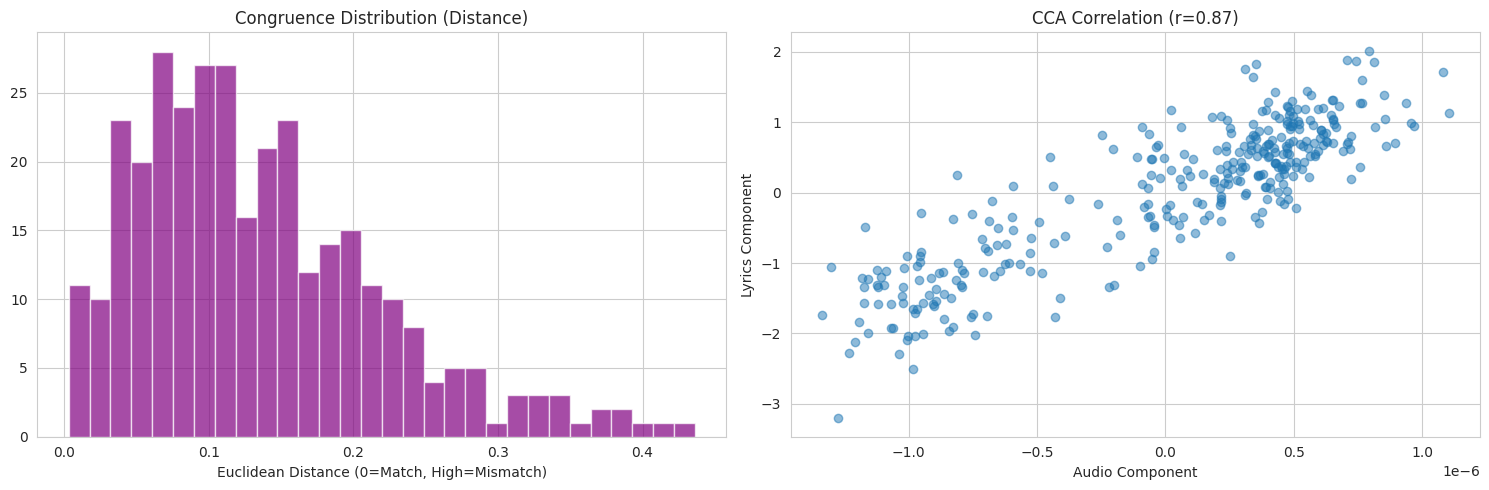

In [21]:
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr
from scipy.spatial.distance import euclidean


print("\n" + "="*70)
print("STARTING POST-TRAINING ANALYSIS")
print("="*70)

def extract_features_for_analysis(audio_model, lyrics_model, dataloader, device):
    """
    Extracts both features (for RSA/CCA) and predictions (for Congruence)
    """
    audio_feats = []
    lyrics_feats = []
    audio_preds = []
    lyrics_preds = []

    audio_model.eval()
    lyrics_model.eval()

    print("Extracting internal features...")
    with torch.no_grad():
        for spec, ids, mask, _ in tqdm(dataloader):
            spec, ids, mask = spec.to(device), ids.to(device), mask.to(device)

            # 1. Extract Audio Features (Before the regressor head)
            a_feat = audio_model.audio_tower(spec)
            a_pred = audio_model.regressor(a_feat)

            # 2. Extract Lyrics Features (Before the regressor head)
            l_out = lyrics_model.lyrics_tower(ids, mask)
            l_feat = l_out.last_hidden_state[:, 0, :]
            l_pred = lyrics_model.regressor(l_feat)

            # Store
            audio_feats.append(a_feat.cpu().numpy())
            lyrics_feats.append(l_feat.cpu().numpy())
            audio_preds.append(a_pred.cpu().numpy())
            lyrics_preds.append(l_pred.cpu().numpy())

    return (np.concatenate(audio_feats), np.concatenate(lyrics_feats),
            np.concatenate(audio_preds), np.concatenate(lyrics_preds))

# 1. Get the data
a_features, l_features, a_predictions, l_predictions = extract_features_for_analysis(
    audio_only_model, lyrics_only_model, test_loader, device
)

# --- ANALYSIS A: CONGRUENCE (DISTANCE) ---
print("\n--- A. Congruence Analysis (Euclidean Distance) ---")
distances = []
for i in range(len(a_predictions)):
    # Measure distance between Audio Opinion and Lyric Opinion
    dist = euclidean(a_predictions[i], l_predictions[i])
    distances.append(dist)

distances = np.array(distances)
print(f"Mean Distance between Audio/Lyrics: {distances.mean():.4f}")
print(f"Standard Deviation: {distances.std():.4f}")
print(f"Most Incongruent (Max Distance): {distances.max():.4f}")

# --- ANALYSIS B: RSA (REPRESENTATIONAL SIMILARITY) ---
print("\n--- B. RSA Analysis (Pattern Matching) ---")
# 1. Audio-to-Audio Similarity
audio_sim_matrix = cosine_similarity(a_features)
# 2. Lyrics-to-Lyrics Similarity
lyrics_sim_matrix = cosine_similarity(l_features)

# 3. Correlate the matrices (excluding diagonal)
mask = ~np.eye(audio_sim_matrix.shape[0], dtype=bool)
rsa_score, _ = pearsonr(audio_sim_matrix[mask], lyrics_sim_matrix[mask])

print(f"RSA Score (Correlation between structures): {rsa_score:.4f}")
if rsa_score > 0.1:
    print("Interpretation: Weak but positive connection between sound and text patterns.")
else:
    print("Interpretation: Audio and Lyrics structures are largely independent.")

# --- ANALYSIS C: CCA (WITH PCA STEP) ---
print("\n--- C. CCA Analysis (Shared Variance) ---")
# 1. PCA Step: Shrink Lyrics from 768 -> 50 dimensions
pca = PCA(n_components=50)
l_features_reduced = pca.fit_transform(l_features)
print("✓ Lyrics reduced via PCA (768 -> 50)")

# 2. CCA Step
cca = CCA(n_components=10)
cca.fit(a_features, l_features_reduced)
a_c, l_c = cca.transform(a_features, l_features_reduced)
cca_corr, _ = pearsonr(a_c[:, 0], l_c[:, 0])

print(f"Top Canonical Correlation: {cca_corr:.4f}")
print("Interpretation: A value close to 0 means they share no information.")
print("                A value close to 1 means they share strong information.")

# --- PLOTTING RESULTS ---
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Congruence Histogram
axes[0].hist(distances, bins=30, color='purple', alpha=0.7)
axes[0].set_title("Congruence Distribution (Distance)")
axes[0].set_xlabel("Euclidean Distance (0=Match, High=Mismatch)")

# Plot 2: CCA Scatter
axes[1].scatter(a_c[:, 0], l_c[:, 0], alpha=0.5)
axes[1].set_title(f"CCA Correlation (r={cca_corr:.2f})")
axes[1].set_xlabel("Audio Component")
axes[1].set_ylabel("Lyrics Component")

plt.tight_layout()
plt.show()